# Distance Averaging Plot
In this notebook, we show multivariate time series distances and their average.

In [1]:
# needed fpr PDF/A
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

from src.utils import load_raw_has_datasets
from claspy.segmentation import BinaryClaSPSegmentation
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

import os
import sys

sys.path.append("../../")

Let's start by loading the data and selecting a time series.

In [3]:
df_data = load_raw_has_datasets()
df_data.head()

,ts_id,ts_challenge_id,group,subject,routine,change_points,activities,split,x-acc,y-acc,z-acc,x-gyro,y-gyro,z-gyro,x-mag,y-mag,z-mag,lat,lon,speed
0,0,125,indoor,1,1,"[1461, 2952, 4473, 5022, 6460]","[jumping jacks, downtoplank, jumping jacks, re...",private,"[0.406, 0.7786, 0.70785, 0.5649, 0.268, -0.035...","[-0.4804, -0.19365, 0.4704, 0.6985, 0.45065, 0...","[1.775, 2.5445, 2.3076499999999998, 1.85993333...","[-0.2425, -0.1857, -0.0446, 0.0733, -0.0122, -...","[1.2022, 1.204, 1.2584, 1.4465, 1.6316, 1.5009...","[-0.0538, -0.0324, 0.0147, 0.0568, 0.0531, -0....","[-24.9, -23.4, -23.4, -23.4, -21.3, -21.3, -21...","[60.3, 62.0, 62.0, 62.0, 61.2, 61.2, 61.2, 62....","[-24.4, -26.1, -26.1, -26.1, -26.9, -26.9, -26...",[],[],[]
1,1,140,indoor,1,1,"[772, 2056, 3521, 4835, 5283, 6893]","[rest, plank, sit ups, plank, rest, jumping ja...",public,"[-0.2274, -0.2274, 0.1261, 0.1261, 0.1261, -0....","[0.5969, 0.5969, 0.1466, 0.1466, 0.1466, 0.515...","[-0.5992, -0.5992, -0.0643, -0.0643, -0.0643, ...","[-0.15955714285714287, -0.1613, -0.10250000000...","[-0.045385714285714286, -0.0391, -0.0080599999...","[-0.1735142857142857, -0.1772, -0.195, -0.2097...","[-29.4, -28.7, -28.7, -28.7, -29.1, -29.1, -29...","[-63.5, -62.4, -62.4, -62.4, -62.7, -62.7, -62...","[-52.2, -52.4, -52.4, -52.4, -52.2, -52.2, -52...",[],[],[]
2,2,93,indoor,1,1,"[1211, 2043, 2836, 3529, 4036]","[plank, squat jump, lunges left, lunges right,...",public,"[4.8883, 4.8883, 4.8883, 4.4134, 4.4134, 4.413...","[5.4784, 5.4784, 5.4784, 5.8291, 5.8291, 5.829...","[-6.4445, -6.4445, -6.4445, -6.0946, -6.0946, ...","[0.060823076923076924, 0.08336, 0.0929, 0.2059...","[0.01392307692307692, -0.00486, -0.0012, 0.018...","[0.054430769230769234, 0.04057, 0.0391, 0.0824...","[-34.2, -34.2, -34.0, -34.0, -34.0, -34.0, -34...","[3.0, 3.0, 2.8, 2.8, 2.8, 4.3, 4.3, 4.3, 4.0, ...","[63.9, 63.9, 64.8, 64.8, 64.8, 64.9, 64.9, 64....",[],[],[]
3,3,52,indoor,1,1,"[739, 1433, 2044, 2875, 3589]","[lunges left, lunges right, rest, squat jump, ...",private,"[-1.2656, -1.2656, -1.2656, -6.6303, -6.6303, ...","[-0.5253, -0.5253, -0.5253, -0.0624, -0.0624, ...","[-3.9209, -3.9209, -3.9209, -4.8733, -4.8733, ...","[-0.47177142857142856, -0.46897142857142854, -...","[0.7421142857142857, 0.44257142857142856, 0.26...","[-0.16341428571428573, -0.4535285714285714, -0...","[-1.7, -2.9, -2.9, -2.9, -4.9, -4.9, -4.9, -5....","[76.8, 75.4, 75.4, 75.4, 74.8, 74.8, 74.8, 74....","[-5.0, -3.7, -3.7, -3.7, -1.2, -1.2, -1.2, 1.5...",[],[],[]
4,4,221,indoor,1,1,"[1506, 3033, 4477, 5348, 6805]","[hiptrust, diagonal, hiptrust, rest, diagonal,...",private,"[-0.8136, -0.8136, -0.8136, -0.1624, -0.1624, ...","[-0.1392, -0.1392, -0.1392, -1.0283, -1.0283, ...","[0.844, 0.844, 0.844, 1.1861, 1.1861, 1.1861, ...","[-0.654675, -0.7183900000000001, -0.7294, -0.7...","[-0.021399999999999995, -0.11534, -0.1124, 0.0...","[0.032975, 0.05033, 0.0452, 0.03444, 0.0851099...","[10.6, 10.6, 10.6, 11.3, 11.3, 11.3, 12.1, 12....","[-69.2, -69.2, -69.2, -64.5, -64.5, -64.5, -60...","[-50.3, -50.3, -50.3, -53.5, -53.5, -53.5, -57...",[],[],[]


In [4]:
idx = 0
row = df_data.iloc[idx, :]

T = row.iloc[8:17].tolist()

We compute the distances and plot them.

In [14]:
D = []

w, p = 50, 500

for time_series in T:
    query = time_series[p:p+w]
    query = (query - np.mean(query)) / np.std(query)
    
    dist = np.zeros(time_series.shape[0] - w + 1, float)
    
    for kdx in range(time_series.shape[0] - w + 1):
        seq = time_series[kdx:kdx+w]
        seq = (seq - np.mean(seq)) / np.std(seq)
        dist[kdx] = np.sqrt(np.sum((query-seq)**2))
        
    trivialMatchRange = (
        int(max(0, p - np.round(w // 2, 0))),
        int(min(p + np.round(w // 2 + 1, 0), time_series.shape[0] - w + 1))
    )

    # med = np.median(channel_dists[dim])
    # mad = np.median(np.abs(channel_dists[dim] - med))
    
    dist[trivialMatchRange[0]:trivialMatchRange[1]] = np.max(dist)
        
    D.append(dist)
    
d_avg = np.mean(np.array(D), axis=0)

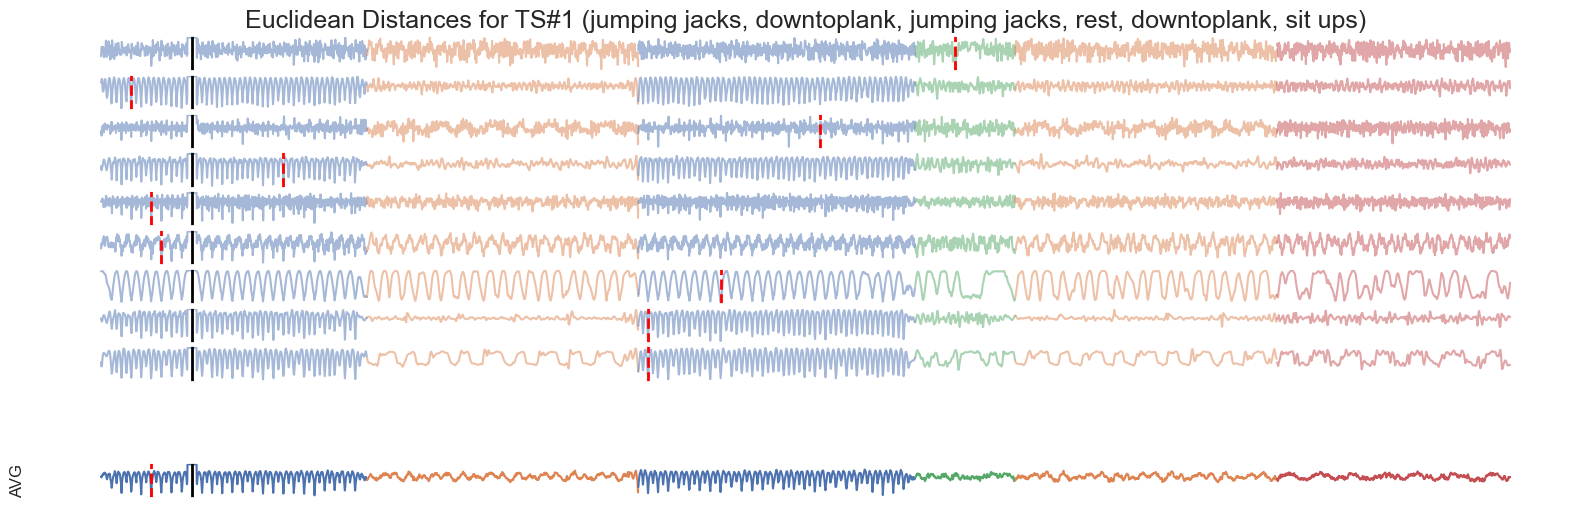

In [20]:
title = f"Euclidean Distances for TS#{row.ts_id+1} ({', '.join(row.activities)})"
time_series = D + [np.zeros(0), np.zeros(0),d_avg]
sensor_names = [""] * (len(time_series)-1) + ["AVG"] # df_data.columns[8:17].tolist()
change_points = row.change_points
activities = row.activities
font_size = 18

fig, axes = plt.subplots(
    len(time_series),
    sharex=True,
    gridspec_kw={'hspace': .1},
    figsize=(20, len(time_series) // 2)
)

activity_colours = {}
idx = 0

for activity in activities:
    if activity not in activity_colours:
        activity_colours[activity] = f"C{idx}"
        idx += 1

for idx, (ts, sensor, ax) in enumerate(zip(time_series, sensor_names, axes)):
    if len(ts) > 0:
        segments = [0] + change_points.tolist() + [ts.shape[0]]
        for kdx in np.arange(0, len(segments) - 1):
            ax.plot(
                np.arange(segments[kdx], segments[kdx + 1]),
                ts[segments[kdx]:segments[kdx + 1]],
                c=activity_colours[activities[kdx]],
                alpha=0.5 if idx < len(time_series) - 3 else 1
            )
        
        ax.axvline(x=p, linewidth=2, color='black')    
        ax.axvline(x=np.argmin(ts), linewidth=2, color='red', linestyle="dashed")

    ax.set_ylabel(sensor, fontsize=12)

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)

    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
        
    ax.set_facecolor((1., 1., 1.))
        
    ax.tick_params(
        axis='both',          
        which='both',      
        labelbottom=False,
        labelleft=False
    )

axes[0].set_title(title, fontsize=18)

plt.savefig("../figures/distance_averaging.pdf", bbox_inches="tight")